# Experiments

## Imports

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.game_matchup as gm
import experiments as exp
import qgrid

## Setup

In [80]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utils functions

In [81]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

## Load Dataset

In [82]:
gm_df = gm.load_game_matchup_dataset()

## Experiments

### Setup

In [83]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [84]:
exp_prefix = ""
exp_group_name = ""
results_total = []
exp.exp_results = []
exp_X_columns = model_config.X_candidate_features
exp_y_columns = model_config.y_candidate_features

### Dataset

El paramatero max_split de la clase TimeSeriesSplit permite dividir el dataset por cantidad de filas, por lo que vamos a escoger solo las temporadas que tienen la misma cantidad de partidos.


In [85]:
gm_df.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [86]:
df = gm_df[gm_df.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

Prueba de como seran dividido el dataset usando TimeSeriesSplit

In [87]:
# tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=1230)
# X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
# print(len(X))
# for train_index, test_index in tscv.split(X=X):
#     print("dtype: ", type(train_index))
#     print("TRAIN:", train_index, "TEST:", test_index)

### Algorithms 

In [88]:
models = exp.get_models()

### Experiment using 1 season

In [92]:
experiment_name = f"{exp_prefix}1_season"

In [93]:
# TimeSeries Cross validation
tscv = list(utils.SeasonTimeSeriesSplit(df).split(train_size=1, test_size=1))
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
params = (experiment_name, df, models, tscv, X, y)
names, results = exp.run_experiment(*params)
results_total.append((experiment_name, results))

NameError: name 'train_splits' is not defined

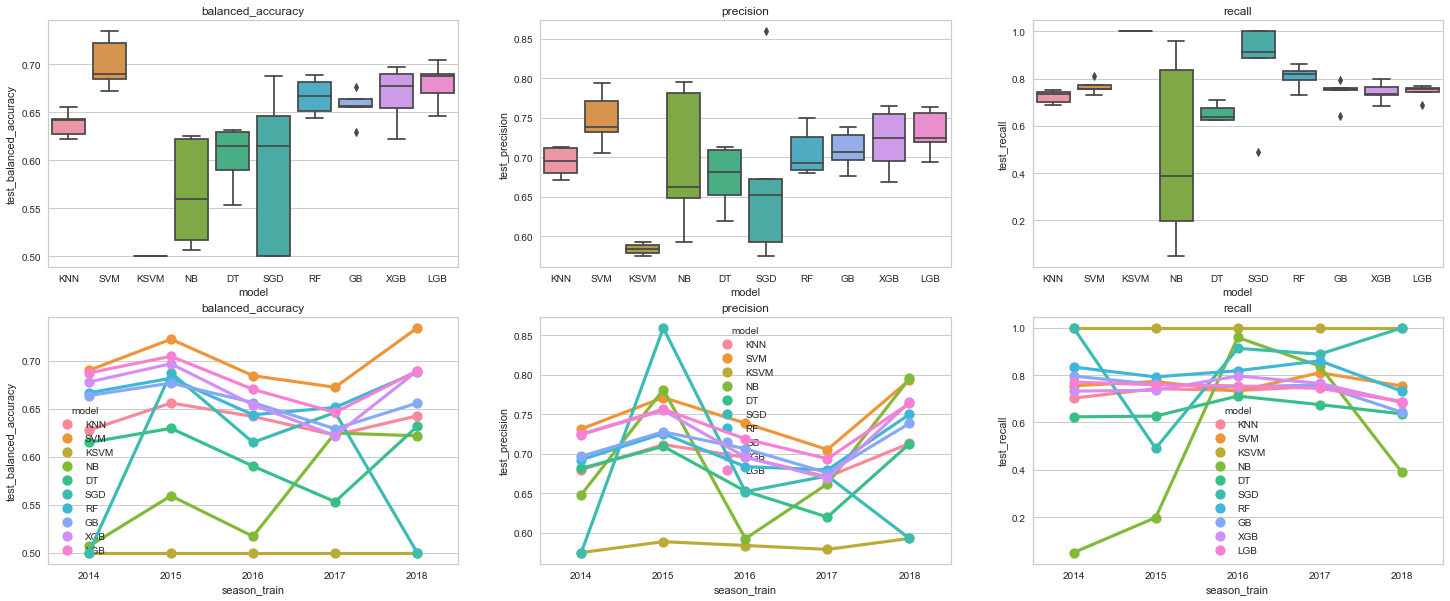

In [32]:
#### Visualize experiments results

Se observa lo siguiente:

- KSVM: siempre predice true o 1, por esta razon en los graficos podemos ver como para la metrica test_balanced_accuracy mantiene un rendimiento constante de 50%, y sin embargo para la metrica test_recall observamos como muestra tambien un rendimiento constante de 100% acierto, dado que el modelo nunca produce falsos negativos.

- Se observa como los algoritmos mas estables

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

### Experiment using StandardScaler

In [33]:
experiment_name = f"{exp_prefix}scaled_data"

In [34]:
train_splits = seasons_size - 1
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
names, results = exp.run_experiment(experiment_name, df, models, tscv, train_splits, X, y, True)
results_total.append((experiment_name, results))

Running experiment scaled_data
KNN
balanced_accuracy: 0.6754298375027097 - 0.01928777264171135
precision: 0.7231651247616558 - 0.025607151150325504
recall: 0.7673378201765793 - 0.04960421218990976
f1: 0.6873606496684703 - 0.015398827658807769
roc_auc: 0.6754298375027097 - 0.01928777264171131
SVM
balanced_accuracy: 0.6531617747424621 - 0.07899025362583809
precision: 0.7101763458443928 - 0.06225331844944021
recall: 0.8020006303000047 - 0.099097445715703
f1: 0.6487460297251312 - 0.10526995497904437
roc_auc: 0.6531617747424618 - 0.07899025362583809
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.006442800896311838
recall: 1.0 - 0.0
f1: 0.43033425003538295 - 0.007748156942408034
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5590693577229467 - 0.05445478110777875
precision: 0.6731920003478212 - 0.07472579176197316
recall: 0.6185823199078793 - 0.3769352404986154
f1: 0.4901341801595132 - 0.11401163468392114
roc_auc: 0.5590693577229467 - 0.054454781107778766
DT
balanced_accuracy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
balanced_accuracy: 0.672157524455305 - 0.01738358898991774
precision: 0.711476113768685 - 0.025276926904617428
recall: 0.8039928850864069 - 0.036965374435656
f1: 0.686671169733639 - 0.015904204292415458
roc_auc: 0.672157524455305 - 0.01738358898991772
GB
balanced_accuracy: 0.6600822404895346 - 0.02364539455991302
precision: 0.7070619734664065 - 0.02718436163970956
recall: 0.776905899431968 - 0.045761254608547595
f1: 0.6737491992485507 - 0.019460481184579183
roc_auc: 0.6600822404895345 - 0.023645394559912943
XGB
balanced_accuracy: 0.6662570033878855 - 0.027521875847614594
precision: 0.71696848618972 - 0.028088611500583536
recall: 0.747989654833211 - 0.030973084344041016
f1: 0.6779144302949291 - 0.026560345619116292
roc_auc: 0.6662570033878855 - 0.027521875847614636
LGB
balanced_accuracy: 0.6851188491240783 - 0.019733629287963083
precision: 0.7347148215571792 - 0.02481062014172969
recall: 0.7509461477884398 - 0.010711774876539966
f1: 0.6950581412467338 - 0.01865787996320996
roc_auc: 0

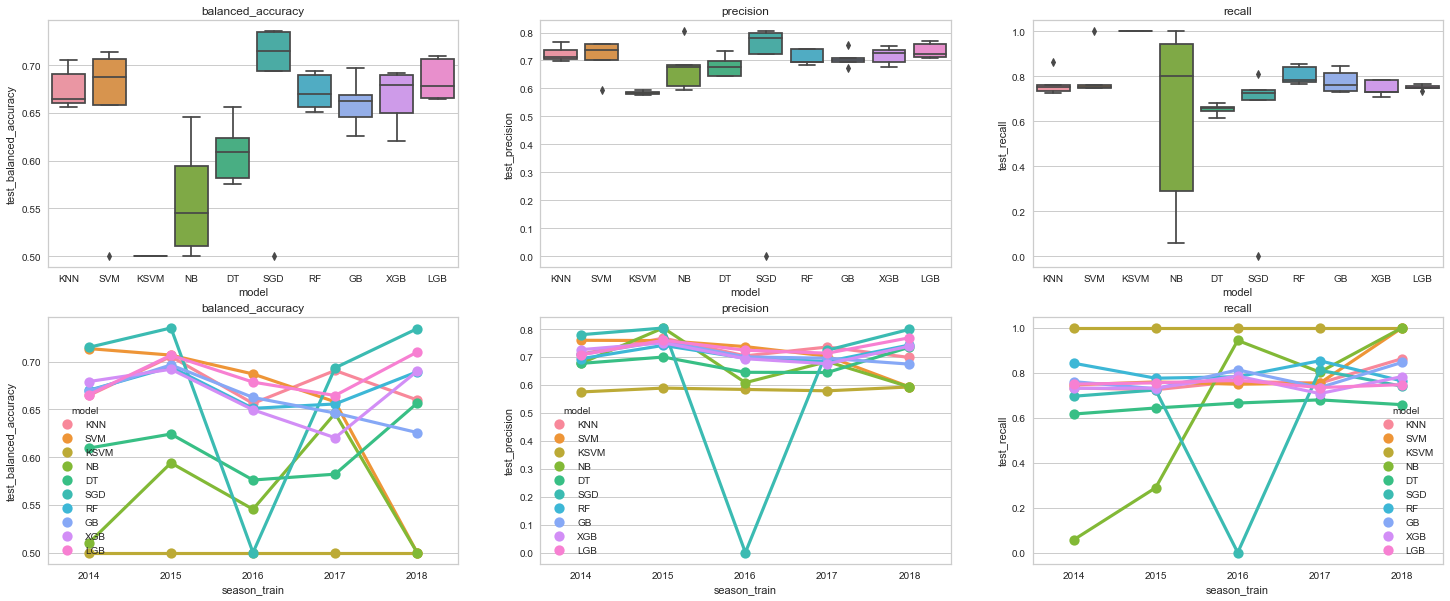

In [35]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

A partir de realizar los siguientes experimentos:

- Entrenar los modelos sin escalar los valores numericos.

### Experiment using 2 seasons

Usando TimeSeriesSplit visualizaremos como sera dividido el modelo

In [24]:
experiment_name = f"{exp_prefix}2_seasons"

In [31]:
tscv = TimeSeriesSplit(n_splits=seasons_size-1, max_train_size=2460)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
print(len(X))
for train_index, test_index in tscv.split(X=X):
    print("dtype: ", type(train_index))
    print("TRAIN:", train_index, "TEST:", test_index)

7380
dtype:  <class 'numpy.ndarray'>
TRAIN: [   0    1    2 ... 1227 1228 1229] TEST: [1230 1231 1232 ... 2457 2458 2459]
dtype:  <class 'numpy.ndarray'>
TRAIN: [   0    1    2 ... 2457 2458 2459] TEST: [2460 2461 2462 ... 3687 3688 3689]
dtype:  <class 'numpy.ndarray'>
TRAIN: [1230 1231 1232 ... 3687 3688 3689] TEST: [3690 3691 3692 ... 4917 4918 4919]
dtype:  <class 'numpy.ndarray'>
TRAIN: [2460 2461 2462 ... 4917 4918 4919] TEST: [4920 4921 4922 ... 6147 6148 6149]
dtype:  <class 'numpy.ndarray'>
TRAIN: [3690 3691 3692 ... 6147 6148 6149] TEST: [6150 6151 6152 ... 7377 7378 7379]


In [25]:
train_splits = seasons_size - 4
tscv = TimeSeriesSplit(n_splits=train_splits, max_train_size=2460)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
# print(len(X))
# for train_index, test_index in tscv.split(X=X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
names, results = exp.run_experiment(experiment_name, df, models, tscv, train_splits, X, y)
results_total.append((experiment_name, results))

Running experiment 2_seasons
KNN
balanced_accuracy: 0.6485616531373359 - 0.008940342835295434
precision: 0.7029568285358301 - 0.010747377705689565
recall: 0.7408988402837065 - 0.011356537925870158
f1: 0.6619918144293718 - 0.007102650793883725
roc_auc: 0.6485616531373359 - 0.008940342835295434
SVM
balanced_accuracy: 0.707048066734512 - 0.0035814778176778694
precision: 0.7590685988079935 - 0.015350005843169312
recall: 0.7572197127707392 - 0.06443191804119691
f1: 0.7146388989251354 - 0.010949188044284686
roc_auc: 0.7070480667345119 - 0.003581477817677925
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5859756097560975 - 0.00020325203252030688
recall: 1.0 - 0.0
f1: 0.4330046812078715 - 0.0002448927025267833
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5240911857436017 - 0.01822248123202236
precision: 0.6215303183622636 - 0.012952440258426123
recall: 0.499630881236158 - 0.43583060384364763
f1: 0.4195862925358751 - 0.11199712428713074
roc_auc: 0.5240911857436017 - 0.01822248123202236
DT
balance

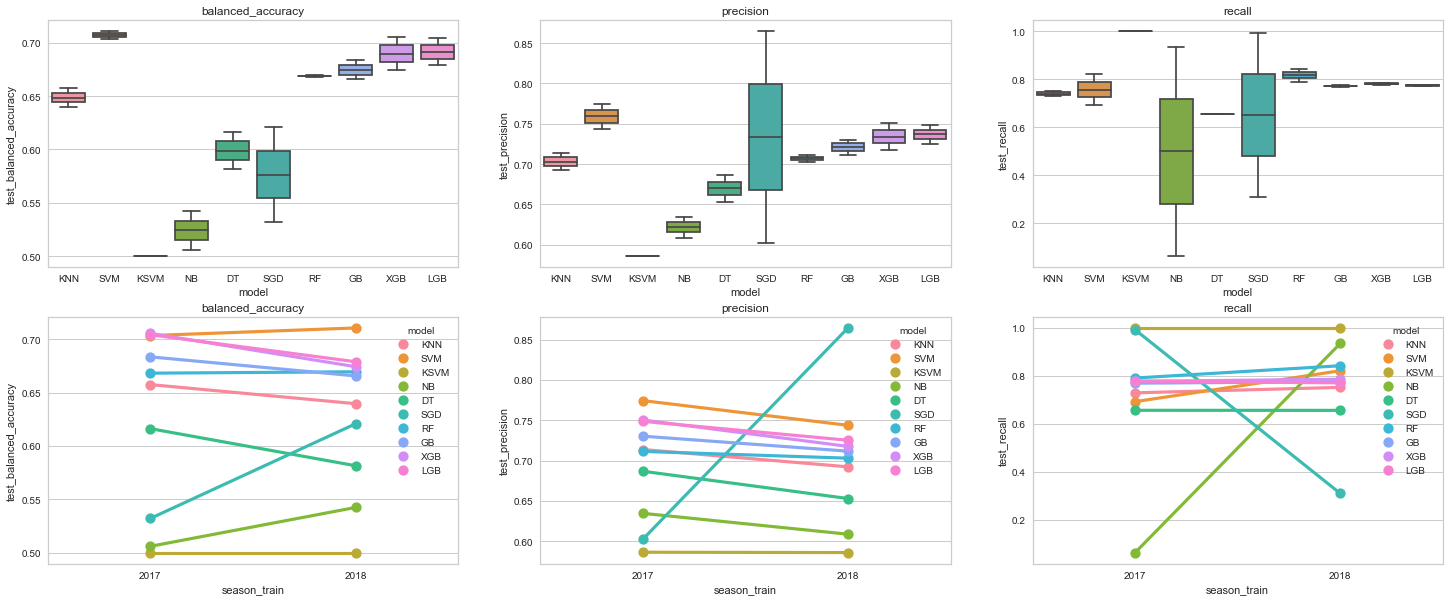

In [38]:
results_df = exp.plot_experiment_results(experiment_name, results)
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

### Experiment quarter split

In [39]:
experiment_name = f"{exp_prefix}4_quarter_pred"

In [40]:
result_size = (seasons_size - 1) * 4
tscv = utils.CustomTimeSeriesSplit(df)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
    
names, results = exp.run_experiment(experiment_name
                                    , df
                                    , models
                                    , list(tscv.split(1))
                                    , (result_size, seasons[-(seasons_size - 1):])
                                    , X, y
                                    , False
                                    , (True, [0.25, 0.5, 0.75, 1]))
results_total.append((experiment_name, results))

Running experiment 4_quarter_pred
KNN
balanced_accuracy: 0.6419239939642382 - 0.03741083507115987
precision: 0.6984133669658543 - 0.03444114976763554
recall: 0.7220225550524944 - 0.04925145454838237
f1: 0.6535757059804816 - 0.03501028149327509
roc_auc: 0.6419239939642382 - 0.03741083507115987
SVM
balanced_accuracy: 0.7015638524462452 - 0.07471642766412112
precision: 0.7480006259317817 - 0.06283016386244257
recall: 0.7887585375697141 - 0.05933882462209672
f1: 0.7133929804094064 - 0.0698792361223614
roc_auc: 0.7015638524462452 - 0.07471642766412112
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.5837281610897247 - 0.024208529414714505
recall: 1.0 - 0.0
f1: 0.43059740049412937 - 0.02891846539640743
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5854041100677441 - 0.06477059953808942
precision: 0.6359436706008779 - 0.2266068089894388
recall: 0.5264513370316641 - 0.3320374366236587
f1: 0.5231054374357135 - 0.14491123461581717
roc_auc: 0.5854041100677441 - 0.06477059953808942


/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DT
balanced_accuracy: 0.6104654508851397 - 0.05145040529748376
precision: 0.6786554069193368 - 0.04581742740829253
recall: 0.665434932505628 - 0.05780729135883707
f1: 0.6200632935531379 - 0.04863182581542495
roc_auc: 0.6104654508851397 - 0.05145040529748373
SGD
balanced_accuracy: 0.5886018554647738 - 0.08132115606213117
precision: 0.70056277430088 - 0.12057798083097732
recall: 0.7670725236550807 - 0.2904119276189632
f1: 0.5437324103355057 - 0.11742129638843381
roc_auc: 0.5886018554647737 - 0.08132115606213115
RF
balanced_accuracy: 0.6680946095622701 - 0.04065463101616879
precision: 0.7058566247649761 - 0.0319269639707429
recall: 0.8188220283458891 - 0.04004266324421137
f1: 0.6850304789672126 - 0.036900559080289455
roc_auc: 0.66809460956227 - 0.040654631016168764
GB
balanced_accuracy: 0.6673352446354743 - 0.046620473523389154
precision: 0.7161559135670624 - 0.03330484883050242
recall: 0.761466579385256 - 0.047207032313603674
f1: 0.6804399238557665 - 0.04251442582480701
roc_auc: 0.667335

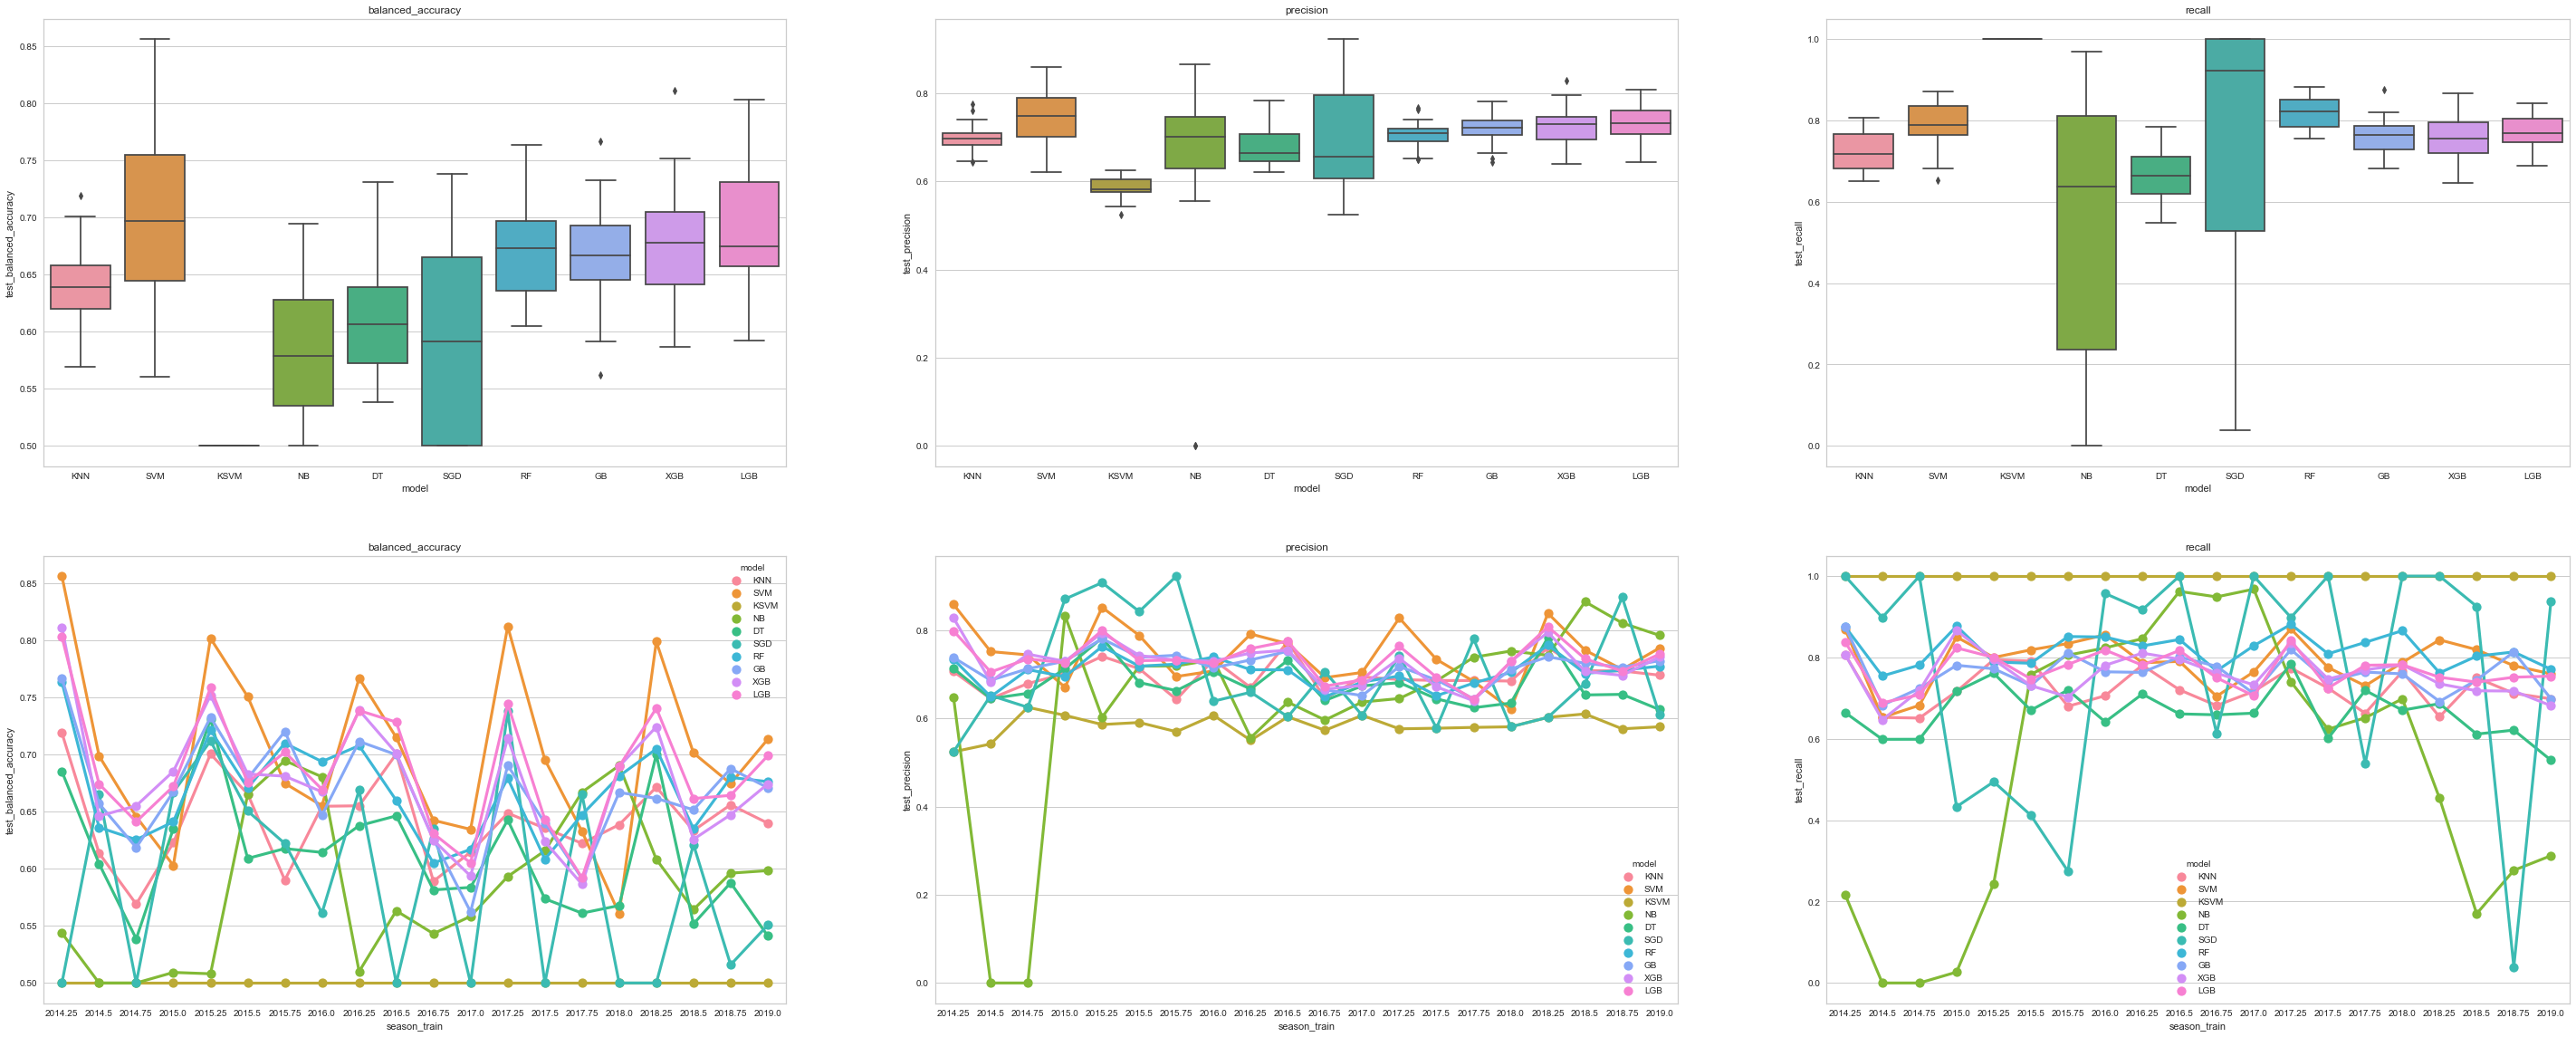

In [41]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

### Experiment 2 quarter split

In [42]:
experiment_name = f"{exp_prefix}2_quarter_pred"

In [43]:
result_size = (seasons_size - 1) * 2
tscv = utils.CustomTimeSeriesSplit(df)
X, y = train.X_y_values(df, exp_X_columns, exp_y_columns)
#for train_index, test_index in tscv.split(1):
    #print("TRAIN:", len(train_index), "TEST:", len(test_index))
    #print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    
names, results = exp.run_experiment(experiment_name
                                    , df
                                    , models
                                    , list(tscv.split(1, [0.5, 1]))
                                    , (result_size, seasons[-(seasons_size - 1):])
                                    , X, y
                                    , False
                                    , (True, [0.5, 1]))
results_total.append((experiment_name, results))

Running experiment 2_quarter_pred
KNN
balanced_accuracy: 0.6395662341349493 - 0.029177513404505032
precision: 0.6959705075568603 - 0.021937874721961275
recall: 0.7218288899506622 - 0.03779072637665509
f1: 0.6517195477193993 - 0.026868072547227104
roc_auc: 0.6395662341349493 - 0.02917751340450502
SVM
balanced_accuracy: 0.6989403047164374 - 0.06359506265000159
precision: 0.7464894233687522 - 0.05479163489088127
recall: 0.7750060093618616 - 0.04794039982786462
f1: 0.7095647003494672 - 0.05880349314581105
roc_auc: 0.6989403047164373 - 0.06359506265000156
KSVM
balanced_accuracy: 0.5 - 0.0
precision: 0.583739837398374 - 0.02079775864106598
recall: 1.0 - 0.0
f1: 0.4305338977084709 - 0.024803264755910923
roc_auc: 0.5 - 0.0
NB
balanced_accuracy: 0.5811467526454516 - 0.06505461497802083
precision: 0.7254438621064965 - 0.11394247964696662
recall: 0.5186903788703437 - 0.3428872577408684
f1: 0.51307664085344 - 0.13916006038858647
roc_auc: 0.5811467526454516 - 0.0650546149780208
DT
balanced_accuracy

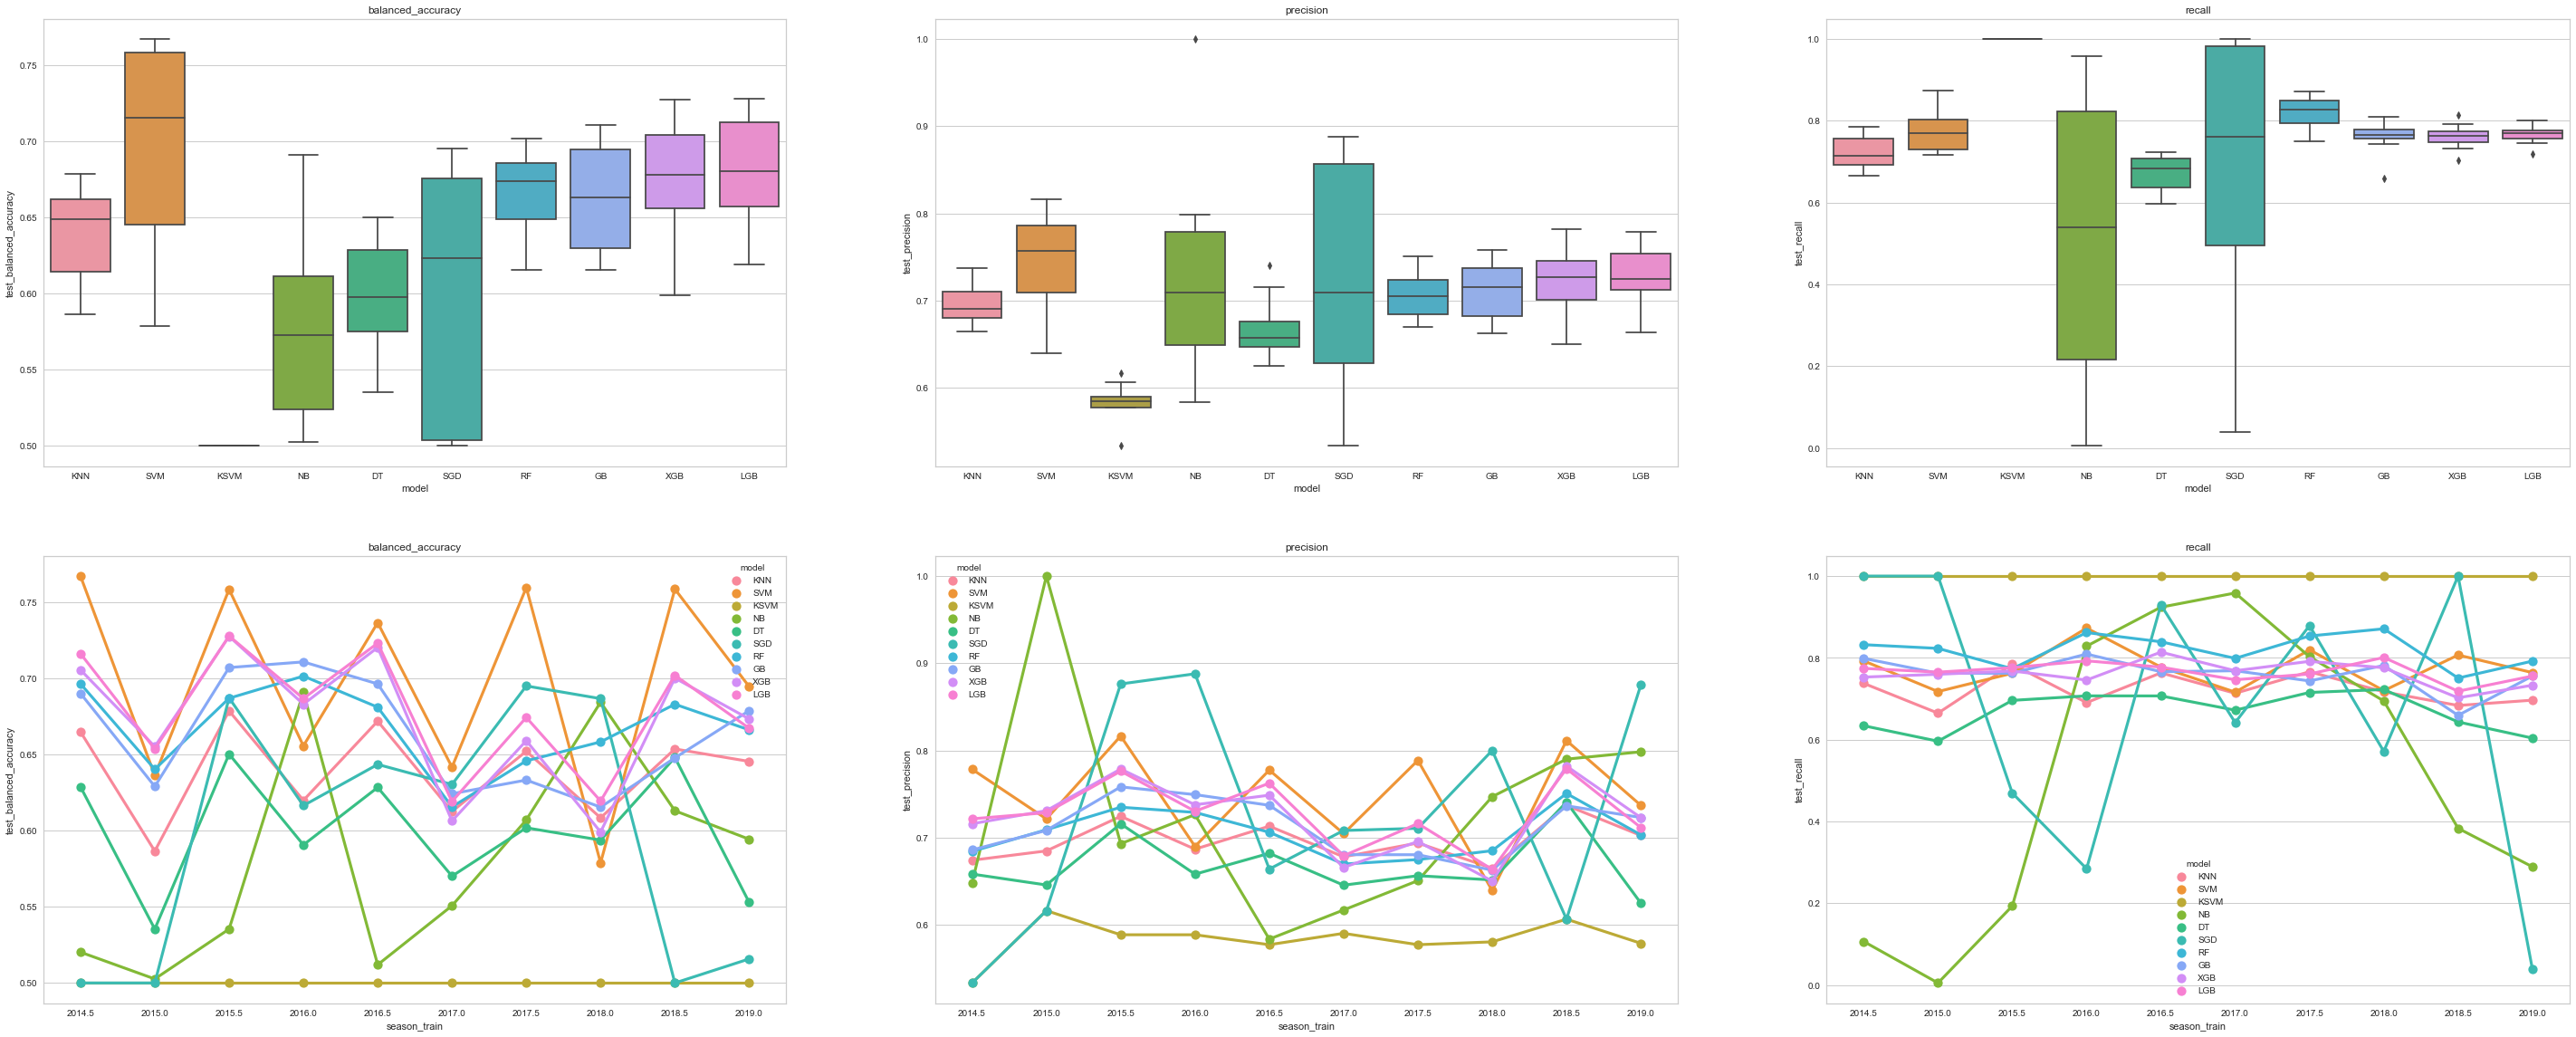

In [44]:
results_df = exp.plot_experiment_results(experiment_name, results, figsize=(50, 20))
results_df.to_pickle(f"./experiments/{experiment_name}_exp.pkl")

## Experiments comparison

In [ ]:
utils.serialize_object(exp_group_name, exp.exp_results)

In [45]:
exp_df = pd.DataFrame(exp.exp_results)

In [46]:
exp_df_sorted = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [47]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df_sorted, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Se observa:

    - KSVM: Es un modelo que se va a descartar ya que solo predice true a todas las instancias. Por esta razon podemos ver como el algoritmo obtuvo un 0.0 de desviacion estandar, ya que no dio ningun falso negativo.

    - Random Forest es el modelo que se presenta mas estable.
    
        Cuando se evaluo con el dataset de dos temporadas obtuvo la mejor desviacion estandar.
    
    - Las tecnicas de normalizacion de features no mostraron cambios significativos, comparados con los experimentos no normalizados.
    
    

### Comparing with other results

## Plot experiment results

In [48]:
utils.serialize_object("results", exp.exp_results)
utils.serialize_object("results_total", results_total)

### Balance Accuracy

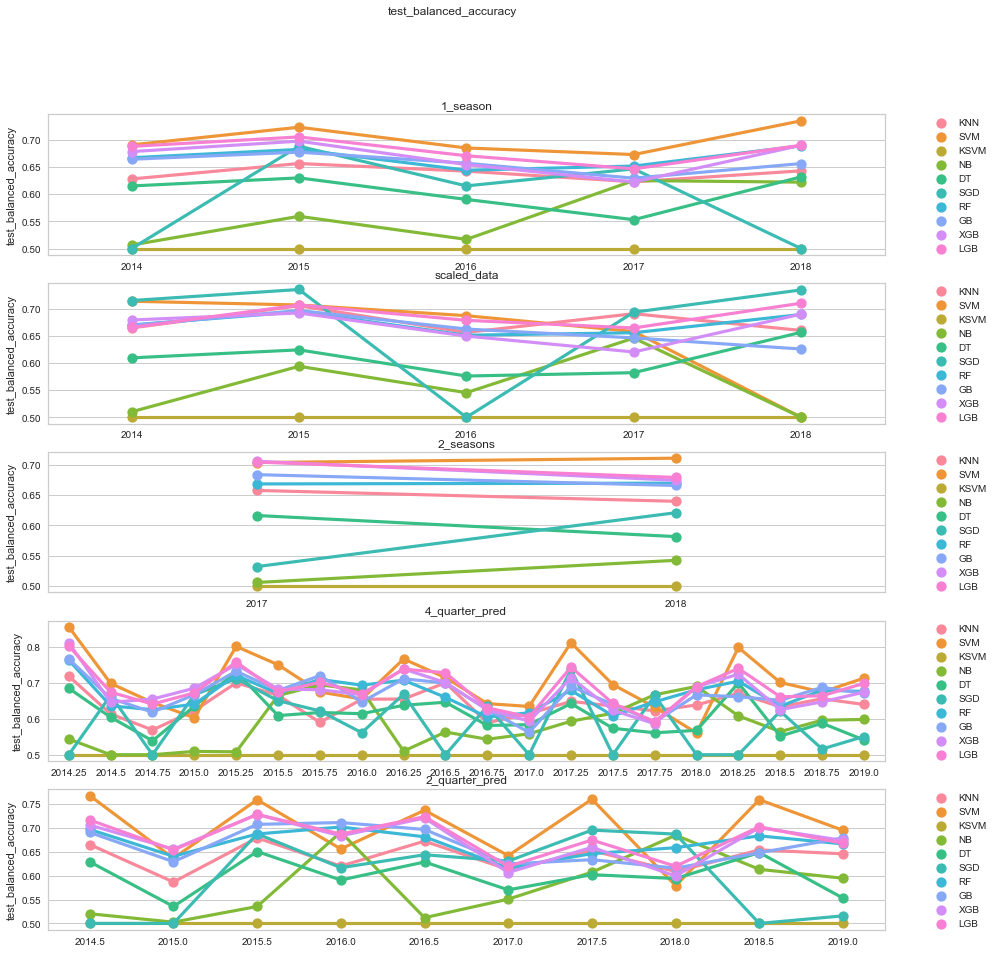

In [49]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_balanced_accuracy", 
    figsize=(15, 15),
    use_pointplot=True
)

### Precision

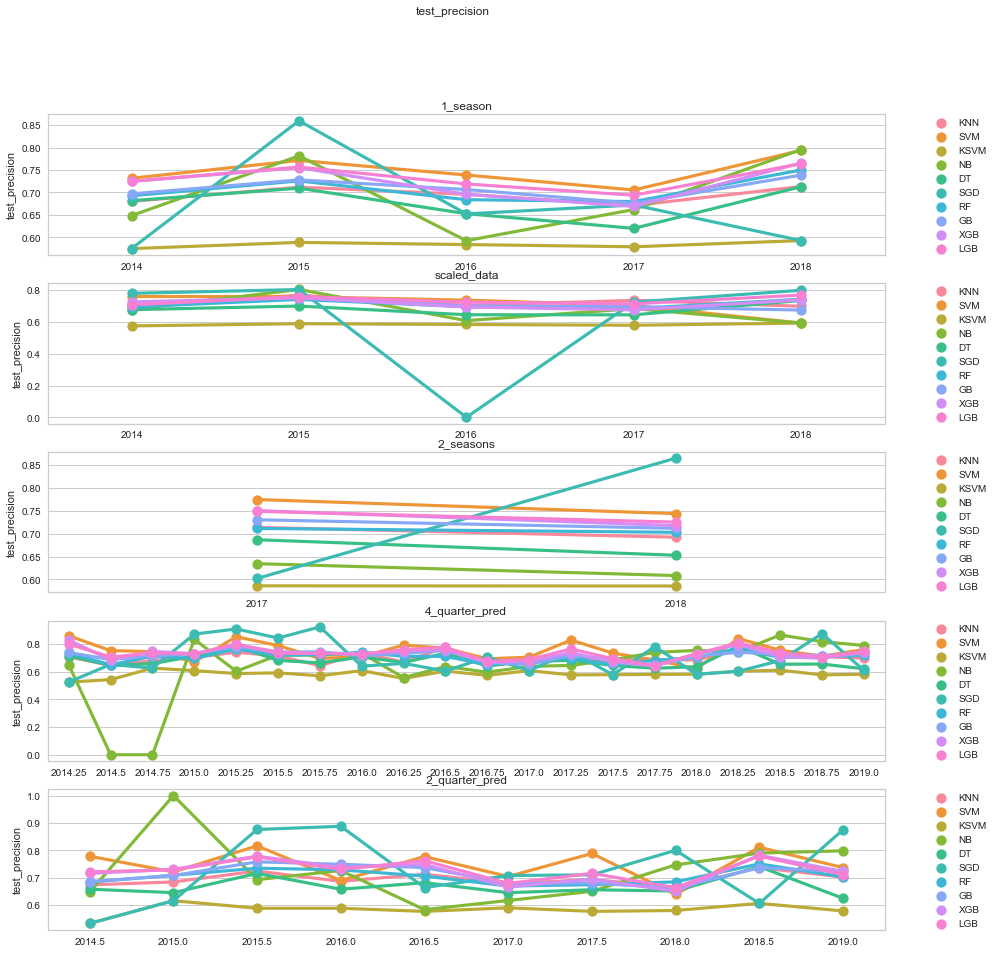

In [50]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_precision", 
    figsize=(15, 15),
    use_pointplot=True
)

### Recall

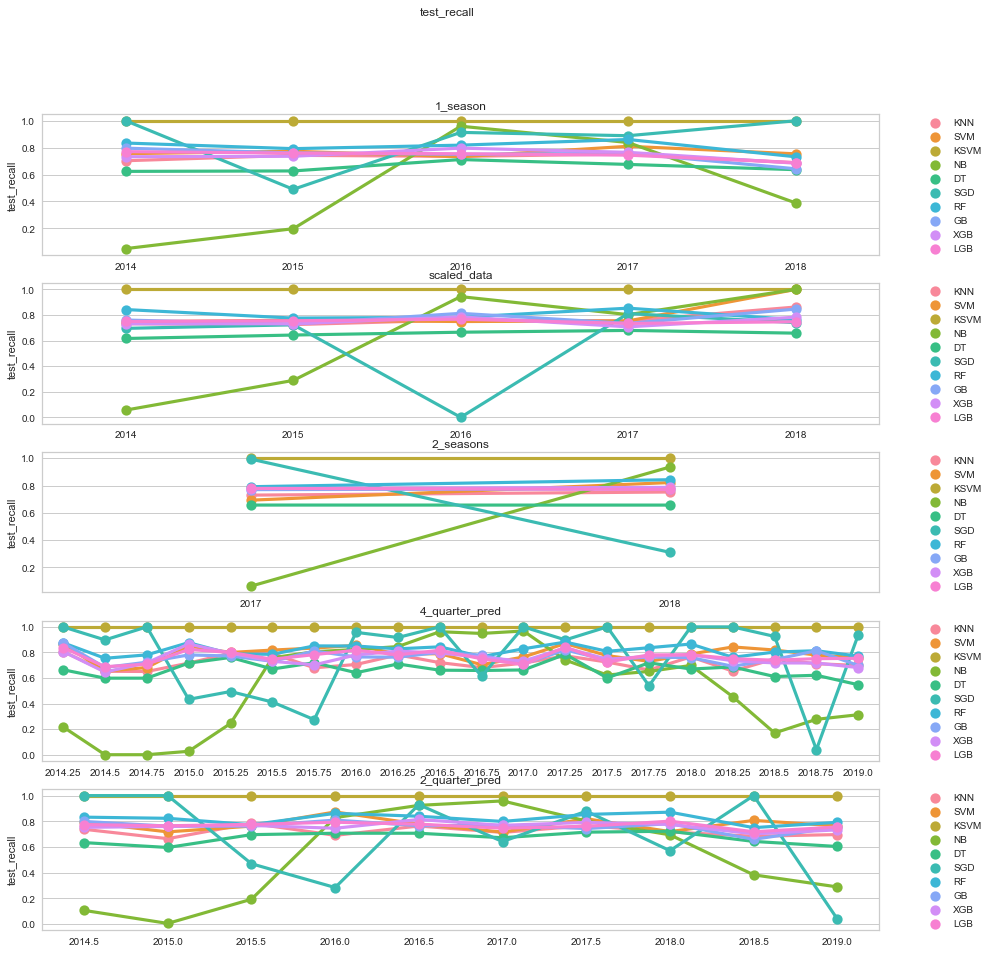

In [51]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_recall", 
    figsize=(15, 15),
    use_pointplot=True
)

### F1

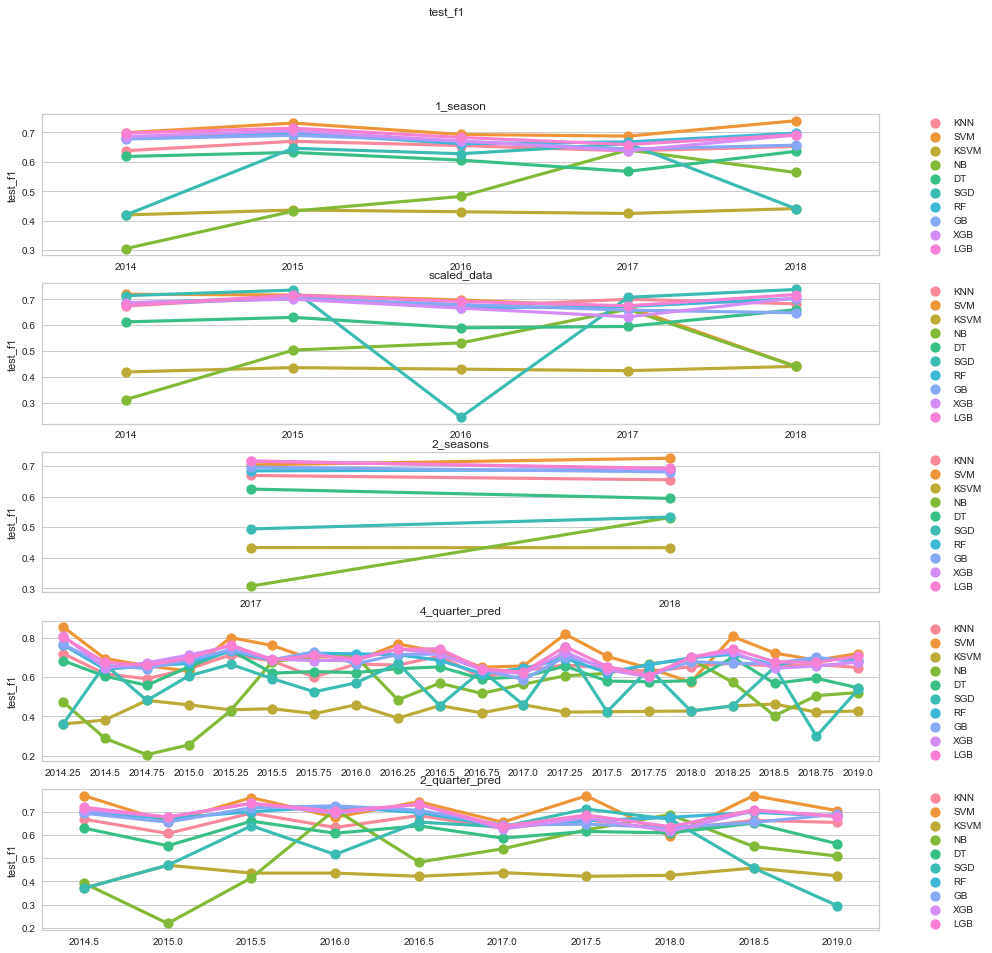

In [52]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_f1", 
    figsize=(15, 15),
    use_pointplot=True
)

### ROC AUC

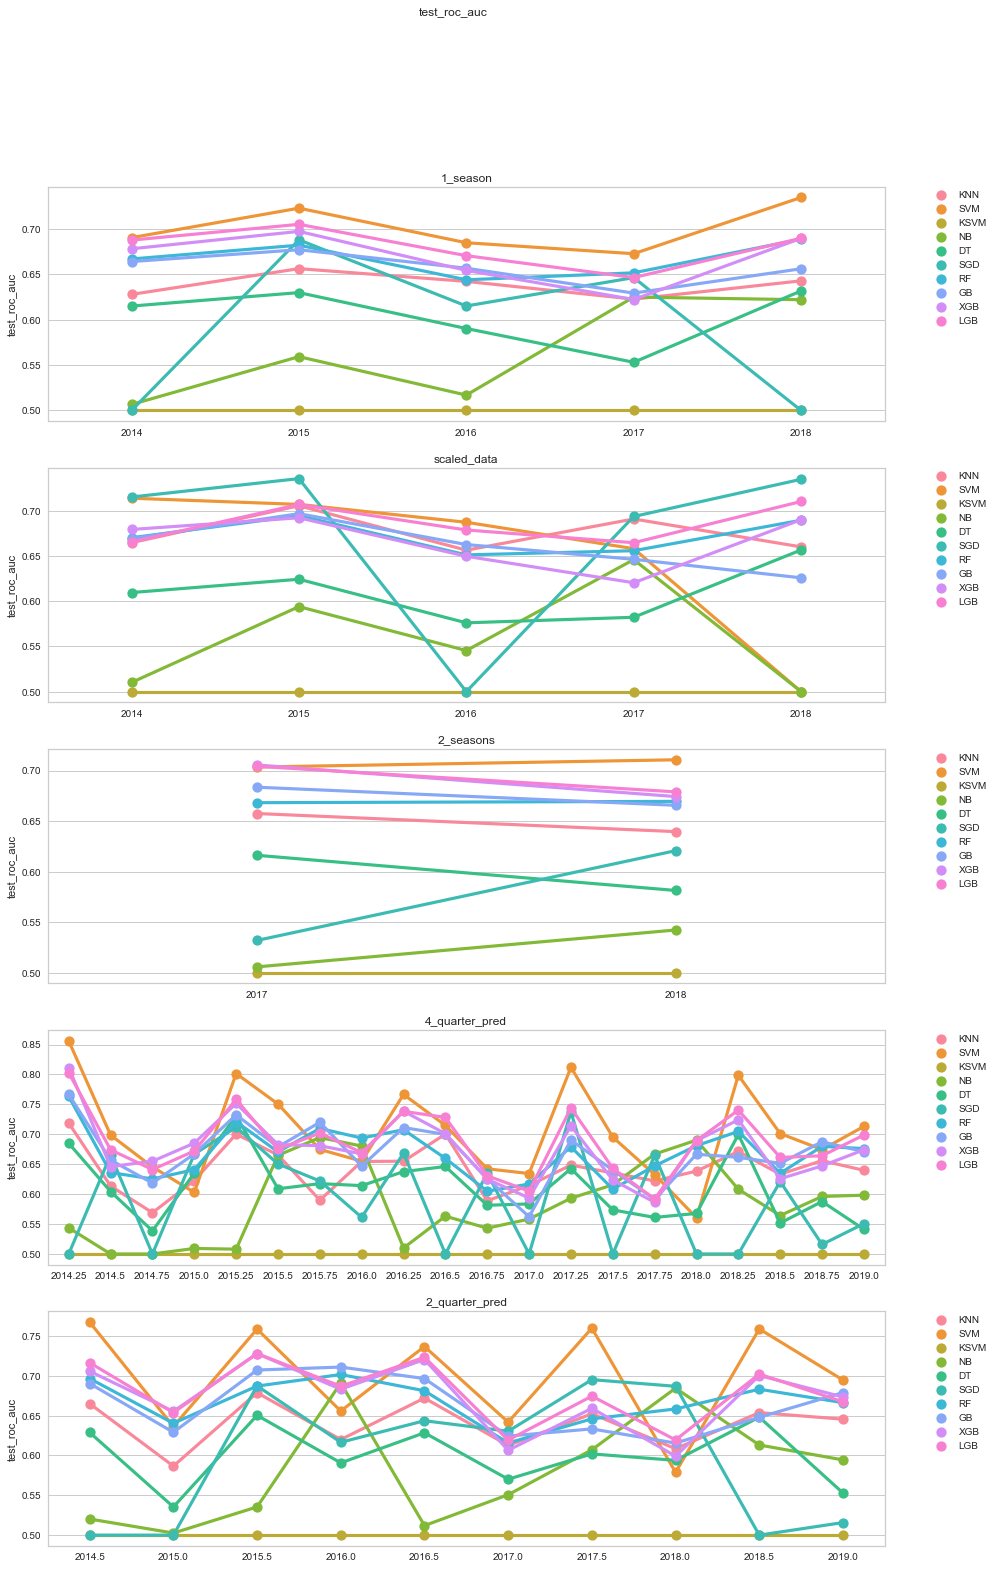

In [53]:
exp.plot_to_compare_experiments(
    results_total, 
    metric="test_roc_auc", 
    figsize=(15, 25),
    use_pointplot=True
)

## Test a specific model

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=1230)
X, y = train.X_y_values(df, model_config.X_for_scale, model_config.y_columns[-1:])
model = SVC(kernel = 'rbf', random_state=0)
for train_index, test_index in tscv.split(X=X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(X[train_index], y[train_index].ravel())
    predictions = model.predict(X=X[test_index])
    percentage = model.score(X[test_index], y[test_index].ravel())
    res = confusion_matrix(y[test_index], predictions)
    print("Confusion Matrix")
    print(res)
    print(f"Test Set: {len(X[test_index])}")
    print(f"Accuracy = {percentage*100} %")
    print(f"balanced_accuracy_score: {balanced_accuracy_score(y[test_index], predictions)}")
    print(f"recall_score: {recall_score(y[test_index], predictions)}")
    # Show confusion matrix in a separate window
    plt.matshow(res)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

results_pred = np.concatenate((predictions.reshape(len(predictions),1), y[test_index].reshape(len(y[test_index]),1)),1)
test_pred = pd.DataFrame(results_pred, columns=["pred", "true"])